## part 1 builidng 5 predictive models 

OLS 
LASSO 
Random Forest 
Boosting 
CART 

## importing 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

import os
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from mizani.formatters import percent_format
from patsy import dmatrices
from plotnine import *
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

In [2]:

data_dir = "/Users/ghadena/Desktop/Business analytics/DA3/DA3/assignment_1/data"
path = os.path.join(data_dir,'airbnb_madrid_workfile_adj.csv') 
df = pd.read_csv(path)
df.head()
df = df.drop(columns=["d_unnamed:59"])

## EDA and sample design 
we did feature engineerng in the cleaning document 

In [3]:
df.isnull().sum().sum()

0

In [4]:
#We focus on normal apartments, n<8
df = df.loc[lambda x: x["n_accommodates"] < 8]

In [5]:
#Copy a variable - purpose later, see at variable importance
df = df.assign(n_accommodates_copy=df.n_accommodates)

In [6]:
df.describe()

,usd_price_day,p_host_response_rate,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_reviews_per_month,n_minimum_nights,n_beds,n_days_since,...,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,n_accommodates_copy
count,20233.000000,20233.0,20233.000000,20233.000000,20233.000000,20233.000000,20233.000000,20233.000000,20233.000000,20233.000000,...,20233.000000,20233.000000,20233.0,20233.000000,20233.000000,20233.000000,2.023300e+04,2.023300e+04,20233.000000,20233.000000
mean,117.980626,0.0,3.019473,1.253398,4.669453,53.026442,1.940280,7.060940,1.829931,6.282932,...,0.170415,0.170415,0.0,6.282932,40.894425,273.354686,1.725053e+06,4.461300e+09,1.534179,3.019473
std,91.768908,0.0,1.521987,0.595112,0.427763,93.815632,1.826741,17.356968,1.243126,1.191328,...,0.376006,0.376006,0.0,1.191328,13.978358,131.588942,3.234207e+06,1.158312e+10,0.135768,1.521987
min,1.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000
25%,60.000000,0.0,2.000000,1.000000,4.610000,2.000000,0.730000,1.000000,1.000000,5.710427,...,0.000000,0.000000,0.0,5.710427,32.608977,186.211182,9.060100e+04,2.727090e+07,1.528228,2.000000
50%,100.000000,0.0,3.000000,1.000000,4.760000,15.000000,1.460000,2.000000,2.000000,6.388561,...,0.000000,0.000000,0.0,6.388561,40.813717,260.740936,3.528360e+05,2.095846e+08,1.560248,3.000000
75%,147.000000,0.0,4.000000,1.000000,4.880000,61.000000,2.540000,3.000000,2.000000,7.023759,...,0.000000,0.000000,0.0,7.023759,49.333190,346.504434,1.258884e+06,1.412468e+09,1.585145,4.000000
max,999.000000,0.0,7.000000,12.000000,5.000000,1092.000000,41.220000,364.000000,40.000000,8.546364,...,1.000000,1.000000,0.0,8.546364,73.040330,624.229217,2.649161e+07,1.363523e+11,1.609438,7.000000


## Creating train and hold out sets 

In [7]:
data_train, data_holdout = train_test_split(df, train_size=0.7, random_state=42)
data_train.shape, data_holdout.shape

((14163, 226), (6070, 226))

In [8]:
basic_vars = [
    "n_accommodates",
    "n_beds",
    "n_days_since",
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "f_neighbourhood_cleansed",
]

reviews = [
    "n_number_of_reviews",
    "flag_n_number_of_reviews",
    "n_review_scores_rating",
    "flag_review_scores_rating",
]

amenities = [col for col in df if col.startswith("d_")]

X1 = [
    "n_accommodates:f_property_type",
    "f_room_type:f_property_type",
    "n_accommodates:n_bathrooms", 
    "n_accommodates:f_room_type", 
    "n_accommodates:d_airconditioning", 
    "n_review_scores_rating:d_pets_allowed", 
    "n_review_scores_rating:d_child_friendly", 
    "n_review_scores_rating:d_free_parking",
    "n_accommodates:d_housekeeping_included",
    "n_review_scores_rating:d_housekeeping_included",
    "d_housekeeping_included:f_property_type",
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_E = basic_vars + reviews + amenities + X1 + X2

In [9]:
import re
from patsy import dmatrices

# Clean column names to remove special characters
data_train.columns = data_train.columns.str.replace(r"[^\w\s]", "_", regex=True)

# Update predictors_2 to match cleaned column names
predictors_1_cleaned = [re.sub(r"[^\w\s]", "_", col) for col in predictors_1]
predictors_2_cleaned = [re.sub(r"[^\w\s]", "_", col) for col in predictors_2]
predictors_E_cleaned = [re.sub(r"[^\w\s:]", "_", col) for col in predictors_E]

# Ensure the cleaned column names are in the dataframe
data_train = data_train.rename(columns=dict(zip(predictors_2, predictors_2_cleaned)))


In [10]:

# # Create missing interaction columns
# for var in X1 + X2:
#     if var not in data_train.columns:
#         # Split the interaction term to get the individual columns
#         col1, col2 = var.split(":")
#         # Create the interaction term
#         data_train[var] = data_train[col1] * data_train[col2]
#         print(f"Created column: {var}")
#     else:
#         print(f"Column already exists: {var}")
        
# # Check the data types of the newly created columns
# for var in X1 + X2:
#     print(f"{var}: {data_train[var].dtype}")

In [11]:
# for var in X1 + X2: 
#     if var  not in data_train.columns:
#         #print(var) 
#         data_train[var] = data_train['f_property_type'] + ":" + data_train['f_neighbourhood_cleansed']
#         print(True)
#     else:
#         print(var)
#         print(False)

## OLS 

In [12]:
predictors_list = [
    predictors_1_cleaned,
    predictors_2_cleaned,
    predictors_E_cleaned
]

# Loop through the predictors, fit the model, and extract the metrics
for i, predictors_cleaned in enumerate(predictors_list, start=1):

    # Create design matrices
    y, X = dmatrices("price ~ " + " + ".join(predictors_cleaned), data_train)

    # Fit the OLS model
    model = sm.OLS(y, X).fit()

    # Extract the R-squared value
    r_squared = model.rsquared

    # Extract the BIC value
    bic = model.bic

    # Calculate the RMSE
    rmse = np.sqrt(model.mse_resid)

    # Print the extracted values
    print(f"Model {i}:")
    print(f"R-squared: {r_squared}")
    print(f"BIC: {bic}")
    print(f"RMSE: {rmse}")
    print("\n")

Model 1:
R-squared: 0.3418964891202958
BIC: 163694.2608988179
RMSE: 74.95001931424191


Model 2:
R-squared: 0.39471896178510635
BIC: 164067.26911376155
RMSE: 72.30071264560408


Model 3:
R-squared: 0.47070498576286635
BIC: 168036.19669061547
RMSE: 69.15990118692672




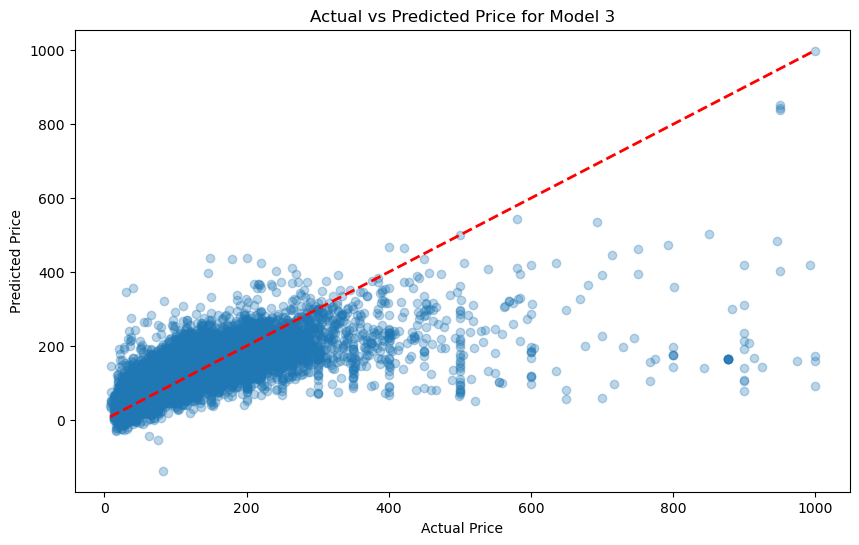

In [17]:

# Create design matrices for model 3
y, X = dmatrices("price ~ " + " + ".join(predictors_E_cleaned), data_train)

# Fit the OLS model for model 3
model = sm.OLS(y, X).fit()

# Predict the values
y_hat = model.predict(X)

# Plot the predicted values versus the actual values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_hat, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price for Model 3')
plt.show()

## Chart 

In [18]:
def price_diff_by_variables(df, factor_var, dummy_var, factor_lab, dummy_lab):
    # Calculate statistics same way as before
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), 
        sd=("price", np.std), 
        size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1/2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()

    # Create the plot using seaborn
    # plt.figure(figsize=(10, 6))
    plt.figure()
    
    # Create bar plot
    ax = sns.barplot(
        data=stats,
        x=stats.columns[0],
        y='Mean',
        hue=stats.columns[1],
        palette=['indianred', 'steelblue'],
        ci=None
    )

    # Add error bars
    for i, group in enumerate(stats[stats.columns[1]].unique()):
        group_data = stats[stats[stats.columns[1]] == group]
        x = np.arange(len(group_data))
        
        # Adjust x positions for dodge effect
        if i == 1:
            x = x + 0.2
        else:
            x = x - 0.2
            
        plt.errorbar(
            x=x, 
            y=group_data['Mean'],
            yerr=[(group_data['Mean'] - group_data['Mean_l']), 
                  (group_data['Mean_u'] - group_data['Mean'])],
            fmt='none',
            color='black',
            capsize=3
        )

    # Customize the plot
    plt.xlabel(factor_lab)
    plt.ylabel('Mean Price')
    
    # Customize legend
    plt.legend(
        title=dummy_lab,
        bbox_to_anchor=(0.5, 1.15),
        loc='center',
        ncol=2,
        fontsize=10,
        title_fontsize=10
    )
    
    # Remove grid
    ax.grid(False)
    plt.show()
    
    return plt



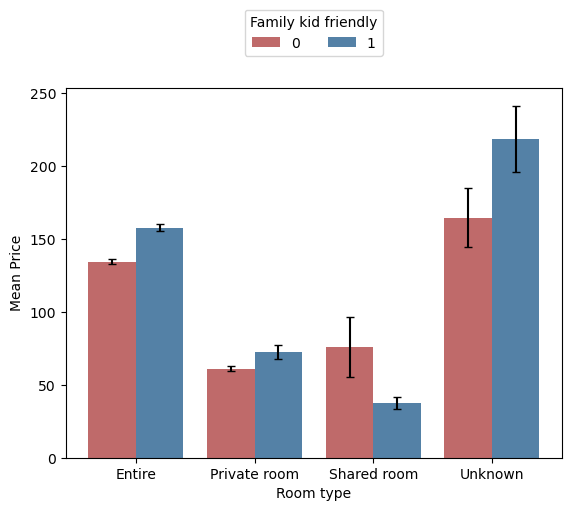

In [20]:
price_diff_by_variables(df,"f_room_type","d_child_friendly","Room type", "Family kid friendly");

## LASSO 

In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
%%time

# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 20250217)
# define grid
grid = dict()
grid["alpha"] = np.arange(0.05, 1, 0.05)
# define search
search = GridSearchCV(model, grid, scoring="neg_root_mean_squared_error", cv = cv, verbose= 3) # control your output with the 'verbose' option
# perform the search
results = search.fit(X, y)